In [100]:
## Nahratie balikov, pouzitie Anaconda Jupyter notebook + updatovane baliky.
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from tqdm import tqdm_notebook
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
from random import sample
from sklearn.utils import shuffle

def power_law(k_min, k_max, y, kappa):
    return ((k_max**(-kappa+1) - k_min**(-kappa+1))*y  + k_min**(-kappa+1.0))**(1.0/(-kappa + 1.0))

np.random.seed(14)

In [101]:
## Funkcie pre ziskavanie agregovanych vysledkov zo simulacie
def sumlist(x):
    tmp=x[0]
    if len(x)>1:
        for i in x[1:]:
            tmp=tmp+i
    return tmp/len(x)

def stdlist_inf(x):
    tmp=pd.DataFrame(x[0].inf)
    if len(x)>1:
        for i in x[1:]:
            tmp=pd.concat([tmp,pd.DataFrame(i.inf)],1)
    return tmp.apply(np.std,1)

def meanlist_inf(x):
    tmp=pd.DataFrame(x[0].inf)
    if len(x)>1:
        for i in x[1:]:
            tmp=pd.concat([tmp,pd.DataFrame(i.inf)],1)    
    return tmp.apply(np.mean,1)

def meanlist_inf_diff(x):
    tmp_list=x
    tmp=pd.DataFrame(tmp_list[0][:,1,:].sum(0)[1:]-tmp_list[0][:,1,:].sum(0)[:-1])
    for i in tmp_list:
         if len(tmp_list)>1:
            for i in x[1:]:
                tmp=pd.concat([tmp,
                               pd.DataFrame(i[:,1,:].sum(0)[1:]-i[:,1,:].sum(0)[:-1])],1)    
    return tmp.apply(np.mean,1)

def stdlist_inf_diff(x):
    tmp_list=x
    tmp=pd.DataFrame(tmp_list[0][:,1,:].sum(0)[1:]-tmp_list[0][:,1,:].sum(0)[:-1])
    for i in tmp_list:
         if len(tmp_list)>1:
            for i in x[1:]:
                tmp=pd.concat([tmp,
                               pd.DataFrame(i[:,1,:].sum(0)[1:]-i[:,1,:].sum(0)[:-1])],1)    
    return tmp.apply(np.std,1)

In [107]:
## Funkcia pre nahratie OD matice
def OD_mat_load(path):
    with open(path,'rb') as f:
        OD=pickle.load(f)
        f.close()
    return OD

# OD=OD_mat_load('./zdroje_int/OD_IFP/OD_final3.pickle')

# Matica mobility? medzi mestami i,j
# zatial je to kompletny graf
OD = np.ones((2926,2926)) #pd.DataFrame(data=[[0,1],[1,0]])
locs_len = OD.shape[0]

In [108]:
# Nahratie populacie
# pop = pd.read_excel('./zdroje_int/munic_pop.xlsx')
# Matica populacie pre 
#pop = pd.DataFrame(data={
#    'munic': [500011,2],
#    'popul': [1,2],
#})

pop = pd.read_csv('./inputs/obce_pocet_obyvatelov.csv')
pop.rename(columns={'kod_obce': 'munic', '2019Q4':'popul'}, inplace=True)

pop_N = np.array(pop['popul'])

# Priradenie populacie k obci
def get_coors_long(x):
    try:
        return float(df_coords.long[df_coords.IDN4.apply(str)==x])
    except:
        return 0
def get_coors_lat(x):
    try:
        return float(df_coords.lat[df_coords.IDN4.apply(str)==x])
    except:
        return 0
#df_coords=pd.read_excel('./zdroje_int/obce1.xlsx')
# df_coords = pd.DataFrame(data={
#     'long': [17.11, 17.99],
#     'lat': [48.11, 48.99],
#     'IDN4': [1, 2]
# })

df_coords = pd.read_json('./inputs/obce_gps.json')
df_coords.rename(columns={'kod_obce': 'IDN4'}, inplace=True)

data_i=pop
data_i.loc[:,'long']=data_i.munic.apply(str).apply(get_coors_long)
data_i.loc[:,'lat']=data_i.munic.apply(str).apply(get_coors_lat)

# Nahratie prvych nakaz
#nakazy_sk=pd.read_excel('./zdroje_int/Cov_data_v0.1_20200328.xlsx', sheet_name = 'final')
nakazy_sk_data = {
    'kod_obce': [1,2],
    'pocet': [1, 2]
}
nakazy_sk = pd.DataFrame(data=nakazy_sk_data)
first_infections=np.zeros(locs_len)
for i in np.arange(nakazy_sk.shape[0]):
    first_infections[pop.munic==nakazy_sk.kod_obce.iloc[i]]=nakazy_sk.pocet.iloc[i]   

first_infections_original=first_infections

In [109]:
## Socio-ekonomicke faktory rizika
#mrk=pd.read_excel('./zdroje_int/KoeficientyR0.xlsx')

mrk_data = [
    [1, 1, 1],
    [2, 2, 2]
]
mrk = pd.DataFrame(data=mrk_data)

mrk.columns=['kod','coef_r0','pct']
mrk.loc[:,'coef_r0']=mrk.coef_r0.apply(lambda x : x**(2/3))

R0_correction_demogr=np.zeros(locs_len)
for i in np.arange(data_i.shape[0]):
    if data_i.munic[i] in set(mrk.kod):
        R0_correction_demogr[np.where(mrk.kod==data_i.munic[i])[0]]=(mrk.coef_r0[mrk.kod==data_i.munic[i]]*mrk.pct[mrk.kod==data_i.munic[i]])+1*(1-mrk.pct[mrk.kod==data_i.munic[i]])

R0_correction_demogr[R0_correction_demogr==0]=1
R0_correction_demogr=R0_correction_demogr**(1/2)

In [110]:
## R0 2.4
if True:
    U = 0.7
    k_min = 0.165
    k_max = 20
    kappa = 2.5
    nodes_izol = round(U*1000000)
    nodes_neizol = 1000000 - nodes_izol
    beta_vec_neizol = np.zeros(nodes_neizol, float)
    for n in range(nodes_neizol):
        beta_vec_neizol[n] = power_law(k_min, k_max, np.random.uniform(0,1), kappa)
    
    # factor to skew gamma distribution towards low values with the same mean and smaller variance
    gamma_factor = 30
    beta = 0.15*gamma_factor
    scale = 1/gamma_factor

    beta_vec_izol = np.random.gamma(beta, scale, nodes_izol)
    gamma = 0.1

    # create joined vector from two distributions
    beta_unsorted = np.transpose([*np.transpose(beta_vec_izol),*np.transpose(beta_vec_neizol)])
    beta_vec = shuffle(beta_unsorted,random_state=0)
    print('R0 mean: ', beta_vec.mean()/ gamma)
    beta_list_240=beta_vec.tolist()
print('R0_izol mean:', beta_vec_izol.mean() / gamma)
print('R0_neizol mean:', beta_vec_neizol.mean() / gamma)

R0 mean:  2.3991435834384247
R0_izol mean: 1.500034050689335
R0_neizol mean: 4.497065826519636


In [111]:
def adjust_beta(beta_new, beta_orig = beta_list_240):
    m = beta_new / np.average(np.array(beta_orig))
    beta_list_new = m * np.array(beta_orig)
    print('New beta average: ', np.average(beta_list_new))
    return beta_list_new.tolist()

# R0 1.65
beta_list_165 = adjust_beta(beta_new = 0.165)
# R0 1.40
beta_list_140 = adjust_beta(beta_new = 0.140)
# R0 1.20
beta_list_120 = adjust_beta(beta_new = 0.120)
# R0 2.00
beta_list_200 = adjust_beta(beta_new = 0.200)

New beta average:  0.165
New beta average:  0.14
New beta average:  0.12
New beta average:  0.20000000000000007


In [112]:
def simulation(N_popul,OD,alpha_vec,R0_correction_demogr,first_infections,beta_list,gamma=0.1,
               tau= 16/24, T = 300):
    
    N_popul = pop.popul.to_numpy()          
    N_munic = len(N_popul)                 
    SIR = np.zeros(shape=(N_munic, 3)) 
    SIR[:,0] = N_popul                      
    SIR[:, 0] = SIR[:, 0] - first_infections
    SIR[:, 1] = SIR[:, 1] + first_infections     # infikovani presunuti do I skupiny
    row_sums = SIR.sum(axis=1)
    SIR_n = SIR / row_sums[:, np.newaxis]
    gamma_vec = np.full(N_munic, gamma)
    SIR_sim = SIR.copy()
    SIR_nsim = SIR_n.copy()
    
    ## Prebiehame simulaciu
    infected_pop_norm = []
    susceptible_pop_norm = []
    recovered_pop_norm = []
    SIR_sim_arr=np.zeros((SIR_sim.shape[0],SIR_sim.shape[1],T))
     
    print('Average beta: ', np.round(np.average(beta_list),3))
    
    SIR_sim_arr=np.zeros((locs_len,3,T))
    w=0
    for time_step in tqdm_notebook(range(T)):
    #for time_step in tqdm.notebook.tqdm(range(T)):
        
        alpha = alpha_vec[w]
        #print('Alpha draw:', alpha)
        ## Transmission rate je na kazdu obec ina, prvotne data su z gamma distribucie
        beta_vec = np.array(sample(beta_list,locs_len))*R0_correction_demogr
        # Matice infekcii
        
        y = SIR_sim[:,0] / N_popul
        x = SIR_sim[:,1] / N_popul
               
        ## Clen 1
        outside_work = beta_vec * SIR_sim[:,0] * SIR_sim[:, 1] / N_popul
        
        ## Clen 2
        # Define the second term
        during_work1 = np.zeros(N_munic) # Second term in the sum
        num_2 = np.zeros(N_munic) # Just to keep the code legible
        denominator_t = N_popul  + OD.sum(axis = 1) - OD.sum(axis = 0)
        num_2=  (SIR_sim[:,0] -y*OD.sum(0))*( np.sum(OD*(x*beta_vec),1)+ (SIR_sim[:,1] - x * OD.sum(0))*beta_vec  )
        ## Clen 3
        during_work1 = num_2/denominator_t
        numerator_t = np.zeros(N_munic)
        numerator_t = ((SIR_sim[:,1]-x*OD.sum(0))*beta_vec + np.sum(OD*beta_vec*x,1))

        during_work2 = np.zeros(N_munic)
        during_work2 = y * np.sum(OD.transpose()*numerator_t/denominator_t,1)
              
        total_new_infect = tau*outside_work + alpha*(1-tau)*during_work1 + alpha*(1-tau)*during_work2      
        ## Nemoze byt viac infikovanych ako susceptible
        total_new_infect = np.where(total_new_infect>SIR_sim[:, 0], SIR_sim[:, 0], total_new_infect)
         
        # Vylieceni
        new_recovered = gamma_vec*SIR_sim[:, 1]
        
        ## Novoinfikovani odchadzaju z kategorie S
        SIR_sim[:, 0] = SIR_sim[:, 0] - total_new_infect
        ## Novoinfikovani prichadzaju do kategorie I a z nej odchadzaju vylieceni
        SIR_sim[:, 1] = SIR_sim[:, 1] + total_new_infect - new_recovered
        ## Vylieceni prichadzaju do kat. R
        SIR_sim[:, 2] = SIR_sim[:, 2] + new_recovered
        SIR_sim = np.where(SIR_sim<0,0,SIR_sim)
        
        # Normalizacia
        row_sums = SIR_sim.sum(axis=1)
        SIR_nsim = SIR_sim / row_sums[:, np.newaxis]
        #SIR_sim_arr[:,:,j]=SIR_sim

        SIR_sim_arr[:,:,w]=SIR_sim
        w=w+1
        S = SIR_sim[:,0].sum()/N_popul.sum()
        I = SIR_sim[:,1].sum()/N_popul.sum()
        R = SIR_sim[:,2].sum()/N_popul.sum()
        infected_pop_norm.append(I)
        susceptible_pop_norm.append(S)
        recovered_pop_norm.append(R)
    ## Vytvorenie konecnej maticu
    res = pd.DataFrame(list(zip(infected_pop_norm, susceptible_pop_norm, recovered_pop_norm)), columns = ['inf','sus','rec'])
    return res,SIR_sim_arr

In [113]:
np.fill_diagonal(OD, 0)
first_infections=first_infections_original*6

N_popul = pop.popul.to_numpy()

## Uprava OD matice, pocet odchodov moze byt maximalne pocet obyvatelov
for j in range(len(N_popul)):
    m = np.sum(OD[:, j]) / N_popul[j]
    if m > 1:
        OD[:, j] = OD[:, j] / m

days = 300
pocet_simulacii = 10

if True:
    percSIR_100_240=[]
    percSIR_070_240=[]
    percSIR_030_200=[]
    percSIR_035_165=[]
    percSIR_035_140=[]
    percSIR_035_120=[]
    SIR_100_240=[]
    SIR_070_240=[]
    SIR_030_200=[]
    SIR_035_165=[]
    SIR_035_140=[]
    SIR_035_120=[]

    for sim in np.arange(pocet_simulacii):
        print('sim:'+str(sim))
        
        alpha1 = 1
        beta_list = beta_list_240
        a1,b1 =simulation(N_popul=pop_N,OD=OD,alpha_vec=np.random.uniform(alpha1-0.1,alpha1+0.1,days),
                              R0_correction_demogr=R0_correction_demogr,
                              first_infections=first_infections,beta_list=beta_list,gamma=0.1,
                              tau= 16/24, T = days)
        alpha2 = 0.7
        beta_list = beta_list_240
        a2,b2 =simulation(N_popul=pop_N,OD=OD,alpha_vec=np.random.uniform(alpha2-0.1, alpha2+0.1,days),
                              R0_correction_demogr=R0_correction_demogr,
                              first_infections=first_infections,beta_list=beta_list,gamma=0.1,
                              tau= 16/24, T = days)
        
        alpha3 = 0.3
        beta_list = beta_list_200
        a3,b3 =simulation(N_popul=pop_N,OD=OD,alpha_vec=np.random.uniform(alpha3-0.1, alpha3+0.1,days),
                              R0_correction_demogr=R0_correction_demogr,
                              first_infections=first_infections,beta_list=beta_list,gamma=0.1,
                              tau= 16/24, T = days)
        
        alpha4 = 0.35
        beta_list = beta_list_165
        a4,b4 =simulation(N_popul=pop_N,OD=OD,alpha_vec=np.random.uniform(alpha4-0.1, alpha4+0.1,days),
                              R0_correction_demogr=R0_correction_demogr,
                              first_infections=first_infections,beta_list=beta_list,gamma=0.1,
                              tau= 16/24, T = days)
        
        alpha5 = 0.35
        beta_list = beta_list_140
        a5,b5 = simulation(N_popul=pop_N,OD=OD,alpha_vec=np.random.uniform(alpha5-0.1, alpha5+0.1,days),
                              R0_correction_demogr=R0_correction_demogr,
                              first_infections=first_infections,beta_list=beta_list,gamma=0.1,
                              tau= 16/24, T = days)
        
        alpha6 = 0.35
        beta_list = beta_list_120
        a6,b6 = simulation(N_popul=pop_N,OD=OD,alpha_vec=np.random.uniform(alpha6-0.1, alpha6+0.1,days),
                                        R0_correction_demogr=R0_correction_demogr,
                                        first_infections=first_infections,beta_list=beta_list,gamma=0.1,
                                        tau= 16/24, T = days)
        
        percSIR_100_240.append(a1)
        percSIR_070_240.append(a2)
        percSIR_030_200.append(a3)
        percSIR_035_165.append(a4)
        percSIR_035_140.append(a5)
        percSIR_035_120.append(a6)
        SIR_100_240.append(b1)
        SIR_070_240.append(b2)
        SIR_030_200.append(b3)
        SIR_035_165.append(b4)
        SIR_035_140.append(b5)
        SIR_035_120.append(b6)
        #with open('./vystupy_model/simulations_29.3.2020_imro_tmp.pickle','wb') as f:
        #    pickle.dump([percSIR_100_240,percSIR_070_240,percSIR_030_200,percSIR_035_165,percSIR_035_140,percSIR_035_120,
        #     SIR_100_240,SIR_070_240,SIR_030_200,SIR_035_165,SIR_035_140,SIR_035_120],f)
   
    results=[percSIR_100_240,percSIR_070_240,percSIR_030_200,percSIR_035_165,percSIR_035_140,percSIR_035_120,
             SIR_100_240,SIR_070_240,SIR_030_200,SIR_035_165,SIR_035_140,SIR_035_120]
    
    #with open('./vystupy_model/simulations_30.3.2020.pickle','wb') as f:
    #    pickle.dump(results,f)

sim:0
Average beta:  0.24


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.24


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.2


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.165


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.14


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.12


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


sim:1
Average beta:  0.24


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.24


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.2


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.165


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.14


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.12


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


sim:2
Average beta:  0.24


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.24


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.2


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.165


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.14


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.12


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


sim:3
Average beta:  0.24


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.24


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.2


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.165


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.14


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.12


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


sim:4
Average beta:  0.24


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.24


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.2


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.165


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.14


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.12


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


sim:5
Average beta:  0.24


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.24


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.2


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.165


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.14


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.12


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


sim:6
Average beta:  0.24


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.24


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.2


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.165


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.14


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.12


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


sim:7
Average beta:  0.24


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.24


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.2


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.165


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.14


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.12


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


sim:8
Average beta:  0.24


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.24


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.2


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.165


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.14


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.12


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


sim:9
Average beta:  0.24


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.24


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.2


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.165


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.14


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


Average beta:  0.12


HBox(children=(IntProgress(value=0, max=300), HTML(value='')))

In [114]:
# with open('./vystupy_model/simulations_30.3.2020.pickle','rb') as f:
#     results=pickle.load(f)
#     f.close()

## Grafy

Alpha 1 R0 2.4, Peak:  0.0 , Day:  0
Alpha 0.7 R0 2.4, Peak:  0.0 , Day:  0
Alpha 0.3 R0 2.4, Peak:  0.0 , Day:  0
Alpha 0.35 R0 2.4, Peak:  0.0 , Day:  0


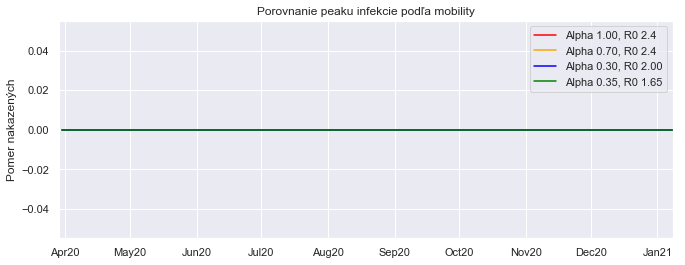

In [115]:
## Graf vrcholov nakazy, standardny
 
total_days = 300

day_zero = dt.datetime.now() - dt.timedelta(days = 3) 
end = day_zero + dt.timedelta(days=total_days)
days = mdates.drange(day_zero,end,dt.timedelta(days=1))

months = mdates.MonthLocator()  # every month

day_zero = dt.datetime.now() - dt.timedelta(days = 3) 
end = day_zero + dt.timedelta(days=total_days)
days = mdates.drange(day_zero,end,dt.timedelta(days=1))

sns.set(rc={'figure.figsize':(11, 4)})    
    
fig, ax = plt.subplots()
clrs=['red','orange','blue','green', 'purple','teal']
with sns.axes_style("darkgrid"):
    for i in range(4):
        means = np.array(meanlist_inf(results[i]), dtype=np.float64)
        sdt = np.array(stdlist_inf(results[i]), dtype=np.float64)
        ax.plot(days, means, c=clrs[i])
        ax.fill_between(days, means-2*sdt, means+2*sdt ,alpha=0.3, facecolor=clrs[i])
        ax.set_xlim([dt.date(2020, 3, 29), dt.date(2021, 1, 8)])
        ax.xaxis.set_major_locator(months)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b' '%y'))

plt.title('Porovnanie peaku infekcie podľa mobility')
plt.ylabel('Pomer nakazených')
plt.legend(['Alpha 1.00, R0 2.4','Alpha 0.70, R0 2.4','Alpha 0.30, R0 2.00','Alpha 0.35, R0 1.65'])

plt.savefig('./outputs/plots/v10_plot_inf_rel_alpha_high.png',dpi=300)
plt.close

means_100_240 = np.array(meanlist_inf(results[0]), dtype=np.float64)
means_070_240 = np.array(meanlist_inf(results[1]), dtype=np.float64)
means_030_200 = np.array(meanlist_inf(results[2]), dtype=np.float64)
means_035_165 = np.array(meanlist_inf(results[3]), dtype=np.float64)

print('Alpha', str(alpha1), 'R0 2.4, Peak: ', np.round(means_100_240.max(),3), ', Day: ' , means_100_240.argmax() )
print('Alpha', str(alpha2), 'R0 2.4, Peak: ', np.round(means_070_240.max(),3), ', Day: ' , means_070_240.argmax())
print('Alpha', str(alpha3), 'R0 2.4, Peak: ', np.round(means_030_200.max(),3),  ', Day: ' , means_030_200.argmax())
print('Alpha', str(alpha4), 'R0 2.4, Peak: ', np.round(means_035_165.max(),3), ', Day: ' , means_035_165.argmax())

In [ ]:
## Graf vrcholov nakazy, nizke scenare
        
total_days = 300

day_zero = dt.datetime.now() - dt.timedelta(days = 3) 
end = day_zero + dt.timedelta(days=total_days)
days = mdates.drange(day_zero,end,dt.timedelta(days=1))
months = mdates.MonthLocator()  # every month

sns.set(rc={'figure.figsize':(11, 4)})    
    
fig, ax = plt.subplots()
clrs=['red','orange','yellow','blue', 'purple','magenta','green']
with sns.axes_style("darkgrid"):
    for i in range(3,6):
        means = np.array(meanlist_inf(results[i]), dtype=np.float64)
        sdt = np.array(stdlist_inf(results[i]),dtype=np.float64)
        ax.plot(days, means, c=clrs[i])
        ax.fill_between(days, means-2*sdt, means+2*sdt ,alpha=0.3, facecolor=clrs[i])
        ax.set_xlim([dt.date(2020, 3, 22), dt.date(2021, 1, 1)])
        ax.xaxis.set_major_locator(months)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b' '%y'))

plt.title('Porovnanie peaku infekcie podľa R0')
plt.ylabel('Pomer nakazených')
plt.legend(['Alpha 0.35, R0 1.65','Alpha 0.35, R0 1.40','Alpha 0.35, R0 1.20'])

plt.savefig('./outputs/plots/v10_plot_inf_rel_low_alpha.png',dpi=300)
plt.close


means_035_165 = np.array(meanlist_inf(results[3]), dtype=np.float64)
means_035_140 = np.array(meanlist_inf(results[4]), dtype=np.float64)
means_035_120 = np.array(meanlist_inf(results[5]), dtype=np.float64)

print('Alpha', str(alpha4), 'R0 1.65, Peak:'  , np.round(means_035_165.max(),3),  ', Day: ' , means_035_165.argmax())
print('Alpha', str(alpha5), 'R0 1.40, Peak:', np.round(means_035_140.max(),3), ', Day: ' , means_035_140.argmax())
print('Alpha', str(alpha6), 'R0 1.20, Peak:', np.round(means_035_120.max(),3), ', Day: ' , means_035_120.argmax())

In [ ]:
sns.set(rc={'figure.figsize':(11, 4)})     

day_zero = dt.datetime.now() - dt.timedelta(days = 2) 
end = day_zero + dt.timedelta(days=299)
days = mdates.drange(day_zero,end,dt.timedelta(days=1))

fig, ax = plt.subplots()
clrs=['red','orange','green','blue']
with sns.axes_style("darkgrid"):
    for i in range(6,10):
        means = np.array(meanlist_inf_diff(results[i]), dtype=np.float64)
        sdt = np.array(stdlist_inf_diff(results[i]), dtype=np.float64)
        ax.plot(days, means, c=clrs[i-6])
        #ax.fill_between(epochs, means-2*sdt, means+2*sdt ,alpha=0.3, facecolor=clrs[i])
        ax.set_xlim([dt.date(2020, 3, 22), dt.date(2021, 1, 1)])
        ax.xaxis.set_major_locator(months)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b' '%y'))


plt.title('Zmena v počte infikovaných')
#plt.xlabel('Dni')
plt.legend(['Alpha 1.0, R0 2.4','Alpha 0.7, R0 2.4','Alpha 0.3, R0 2.0','Alpha 0.35, R0 1.65'])
#plt.ylabel('Počet')
plt.savefig('./outputs/plots/v10_plot_inf_abs.png',dpi=300)
plt.close

## Tabuľky

In [ ]:
## Tabulka 1
days = 300
A = pd.DataFrame({'Dni':np.arange(1, days+1),
              'I_high':np.sum(sumlist(results[6])[:,1,:], axis = 0),
              'I_med':np.sum(sumlist(results[7])[:,1,:], axis = 0),
              'I_low':np.sum(sumlist(results[8])[:,1,:], axis = 0),
              'I_low_R140':np.sum(sumlist(results[9])[:,1,:], axis = 0)
             })

A.columns = ['Dni', 'Alpha 1.0, R0 2.4, Počet infikovaných','Alpha 0.7, R0 2.4, Počet infikovaných',
             'Alpha 0.3, R0 2.0, Počet infikovaných','Alpha 0.35, R0 1.65, Počet infikovaných'] 


# Vyber konkretnych dni (Riadok 9 predstavuje den 10)
A = A.iloc[ [9,19,29,39,49,59,79,99,149,199] , :]

A.to_excel('./outputs/tabulky/v10_Tabulka1.xlsx',engine='xlsxwriter', index = False)

## Tabulka 3 (Tabulka 2 je staticka) -- tabulka pouziva scenar s najprisnejsimi opatreniami
B = A.loc[:, ['Dni', 'Alpha 0.35, R0 1.65, Počet infikovaných']].copy()
B.columns = ['Dni', 'Počet infikovaných']
B['Symptomatickí pacienti'] = B['Počet infikovaných']*0.6
B['Hospitalizácie'] = B['Symptomatickí pacienti']*0.074306
B['Vyžadujúci intenzívnu starostlivosť'] = B['Hospitalizácie']*0.1375

B.to_excel('./outputs/tabulky/v10_Tabulka3.xlsx',engine='xlsxwriter', index = False)

In [ ]:
## Vystup alpha 0.7, R0 2.40
gamma = 0.1

sim_df_low = pd.DataFrame({'Dni':np.arange(1,301),
                       'S': np.sum(sumlist(results[7])[:,0,:], axis = 0),
                       'I': np.sum(sumlist(results[7])[:,1,:], axis = 0),
                       'R': np.sum(sumlist(results[7])[:,2,:], axis = 0)})

sim_df_low['Populácia'] = sim_df_low['S'] + sim_df_low['I'] +sim_df_low['R']
sim_df_low['I_cum'] =  sim_df_low['Populácia'] - sim_df_low['S']

new_infect = np.array(-sim_df_low['S'].iloc[1:]) + np.array(sim_df_low['S'].iloc[0:-1]) 
new_infect = np.insert(new_infect, 0, first_infections.sum() , axis = 0)
new_recovered = np.array( sim_df_low['R'].iloc[1:]) -np.array(sim_df_low['R'].iloc[0:-1]) 
new_recovered = np.insert(new_recovered, 0, gamma*first_infections.sum() , axis = 0)

sim_df_low['Nové infekcie'] = new_infect
sim_df_low['Novovyliečení'] = new_recovered

sim_df_low.columns = ['Dni','Náchylní','Infikovaní','Vyliečení', 'Populácia','Niekedy infikovaní','Nové infekcie', 'Novovyliečení']
sim_df_low.to_excel('./outputs/tabulky/v10_SIR_vystup_alpha_0.70_R0_2.40.xlsx', index = False)
#sim_df_low['Infikovaní'].max()

In [ ]:
## Vystup alpha 0.35, R0 1.65 -- default
sim_df_low = pd.DataFrame({'Dni':np.arange(1,301),
                       'S': np.sum(sumlist(results[9])[:,0,:], axis = 0),
                       'I': np.sum(sumlist(results[9])[:,1,:], axis = 0),
                       'R': np.sum(sumlist(results[9])[:,2,:], axis = 0)})

sim_df_low['Populácia'] = sim_df_low['S'] + sim_df_low['I'] +sim_df_low['R']
sim_df_low['I_cum'] =  sim_df_low['Populácia'] - sim_df_low['S']

new_infect = np.array(-sim_df_low['S'].iloc[1:]) + np.array(sim_df_low['S'].iloc[0:-1]) 
new_infect = np.insert(new_infect, 0, first_infections.sum() , axis = 0)
new_recovered = np.array( sim_df_low['R'].iloc[1:]) -np.array(sim_df_low['R'].iloc[0:-1]) 
new_recovered = np.insert(new_recovered, 0, gamma*first_infections.sum() , axis = 0)

sim_df_low['Nové infekcie'] = new_infect
sim_df_low['Novovyliečení'] = new_recovered

sim_df_low.columns = ['Dni','Náchylní','Infikovaní','Vyliečení', 'Populácia','Niekedy infikovaní','Nové infekcie', 'Novovyliečení']
sim_df_low.to_excel('./outputs/tabulky/v10_SIR_vystup_alpha_0.35_R0_1.65_DEFAULT.xlsx', index = False)
#sim_df_low['Infikovaní'].max()

In [ ]:
## Vystup alpha 0.35, R0 1.40
sim_df_low = pd.DataFrame({'Dni':np.arange(1,301),
                       'S': np.sum(sumlist(results[10])[:,0,:], axis = 0),
                       'I': np.sum(sumlist(results[10])[:,1,:], axis = 0),
                       'R': np.sum(sumlist(results[10])[:,2,:], axis = 0)})

sim_df_low['Populácia'] = sim_df_low['S'] + sim_df_low['I'] +sim_df_low['R']
sim_df_low['I_cum'] =  sim_df_low['Populácia'] - sim_df_low['S']

new_infect = np.array(-sim_df_low['S'].iloc[1:]) + np.array(sim_df_low['S'].iloc[0:-1]) 
new_infect = np.insert(new_infect, 0, first_infections.sum() , axis = 0)
new_recovered = np.array( sim_df_low['R'].iloc[1:]) -np.array(sim_df_low['R'].iloc[0:-1]) 
new_recovered = np.insert(new_recovered, 0, gamma*first_infections.sum() , axis = 0)

sim_df_low['Nové infekcie'] = new_infect
sim_df_low['Novovyliečení'] = new_recovered

sim_df_low.columns = ['Dni','Náchylní','Infikovaní','Vyliečení', 'Populácia','Niekedy infikovaní','Nové infekcie', 'Novovyliečení']
sim_df_low.to_excel('./outputs/tabulky/v10_SIR_vystup_alpha_0.35_R0_1.40.xlsx', index = False)
#sim_df_low['Infikovaní'].max()

In [ ]:
D = pd.DataFrame({'Dni':np.arange(300),
                  'S_high': np.sum(sumlist(results[6])[:,0,:], axis = 0),
                 'S_med': np.sum(sumlist(results[7])[:,0,:], axis = 0),
                 'S_low': np.sum(sumlist(results[8])[:,0,:], axis = 0),
                 'S_low2': np.sum(sumlist(results[9])[:,0,:], axis = 0)})

N = np.sum(pop.popul.to_numpy())
D['I_cum_high'] = N - D['S_high']
D['I_cum_med'] = N -  D['S_med']
D['I_cum_low'] = N -  D['S_low']
D['I_cum_low2'] = N - D['S_low2']

D = D.drop(['S_high', 'S_med', 'S_low', 'S_low2'], axis = 1)

## Graf poctu novych nakaz v case
new_inf_high = np.array(D['I_cum_high'].iloc[1:]) - np.array(D['I_cum_high'].iloc[0:-1])
new_inf_med  = np.array(D['I_cum_med'].iloc[1:]) - np.array(D['I_cum_med'].iloc[0:-1])
new_inf_low  = np.array(D['I_cum_low'].iloc[1:]) - np.array(D['I_cum_low'].iloc[0:-1])
new_inf_low2 = np.array(D['I_cum_low2'].iloc[1:]) - np.array(D['I_cum_low2'].iloc[0:-1])

E = pd.DataFrame({'Deň':np.array(range(1,300,1)), 
                  'Nové infekcie, vysoká mobilita': new_inf_high, 'Nové infekcie, stredná mobilita':new_inf_med, 
                  'Nové infekcie, nízka mobilita, R0 2.0':new_inf_low, 'Nové infekcie, nízka mobilita, R0 1.65':new_inf_low2})

sns.set(rc={'figure.figsize':(11, 4)})    

day_zero = dt.datetime.now() - dt.timedelta(days = 2) 
end = day_zero + dt.timedelta(days=299)
days = mdates.drange(day_zero,end,dt.timedelta(days=1))

fig, ax = plt.subplots()
clrs=['red','orange','green','blue']
with sns.axes_style("darkgrid"):
    epochs = list( E['Deň'] )    
    for i in range(4):
        means = np.array(E.iloc[:, i+1] , dtype=np.float64)
        ax.plot(days, means, c=clrs[i])
        ax.set_xlim([dt.date(2020, 3, 22), dt.date(2021, 1, 1)])
        ax.xaxis.set_major_locator(months)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b' '%y'))

plt.title('Počet nových infekcií')
plt.legend(['Alpha 1.0, R0 2.4','Alpha 0.7, R0 2.4','Alpha 0.3, R0 2.0','Alpha 0.35, R0 1.65'])
#plt.ylabel('Počet')
plt.savefig('./outputs/plots/v10_plot_inf_nove.png',dpi=300)
plt.close